In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !pip install mne

In [3]:
# !pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html -U

In [4]:
######################################################################################################
#  ________   _________   ___    ___ ___  ___  ________  ________  ___  __      _______   _______
# |\   ___  \|\___   ___\|\  \  /  /|\  \|\  \|\   __  \|\   ____\|\  \|\  \   /  ___  \ /  ___  \
# \ \  \\ \  \|___ \  \_|\ \  \/  / | \  \\\  \ \  \|\  \ \  \___|\ \  \/  /|_/__/|_/  //__/|_/  /|
#  \ \  \\ \  \   \ \  \  \ \    / / \ \   __  \ \   __  \ \  \    \ \   ___  \__|//  / /__|//  / /
#   \ \  \\ \  \   \ \  \  /     \/   \ \  \ \  \ \  \ \  \ \  \____\ \  \\ \  \  /  /_/__  /  /_/__
#    \ \__\\ \__\   \ \__\/  /\   \    \ \__\ \__\ \__\ \__\ \_______\ \__\\ \__\|\________\\________\
#     \|__| \|__|    \|__/__/ /\ __\    \|__|\|__|\|__|\|__|\|_______|\|__| \|__| \|_______|\|_______|
#                        |__|/ \|__|
######################################################################################################

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from torch.utils.data import Dataset, DataLoader
from mne.decoding import Vectorizer
torch.manual_seed(42)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [6]:
# Path to training data
train_path = "/home/deepak/learning_project/student/BrainAge/training/"

In [7]:
# Path to testing data (public test set)
test_path = "/home/deepak/learning_project/student/BrainAge/testing_flat/"

In [8]:
condition_ec = "EC"  # closed eyes condition
condition_eo = "EO"  # closed eyes condition
train_subj = 1100  # use 1100 of the 1200 training subjects for training
val_subj = 100   # use 100 of the 1200 training subjects for validation
test_subj = 400  # use 10 instead of 400 testing subjects, for demonstration purpose

In [9]:
class CustomDataset(Dataset):
    def __init__(self, path, subj, ages, start):
        self.path = path
        self.subj = subj
        self.ages = ages
        self.start = start
    def __len__(self):
        return self.subj
    def __getitem__(self, idx):
        s = idx + self.start
        fname = f"subj{s:04}_{condition_eo}_raw.fif.gz"
        raw = mne.io.read_raw(self.path + fname, preload=True, verbose='warning')
        d = raw.get_data()
        ft = d.shape[-1]
        data_eo = torch.zeros(1, 129, 10000)
        data_eo[:, :, :ft] = -200 * torch.tensor(d)
        fname = f"subj{s:04}_{condition_ec}_raw.fif.gz"
        raw = mne.io.read_raw(self.path + fname, preload=True, verbose='warning')
        d = raw.get_data()
        ft = d.shape[-1]
        data_ec = torch.zeros(1, 129, 20000)
        data_ec[:, :, :ft] = -200 * torch.tensor(d)
        data = (data_eo, data_ec)
        age = self.ages[idx]
        return data, age

In [10]:
# get the age to predict from the CSV file
meta = pd.read_csv(train_path + "train_subjects.csv")
y_train = []
for age in meta.age[:1200]:
    y_train.append(age)
print(np.min(y_train), np.mean(y_train), np.median(y_train), np.max(y_train))

5.005932 10.356727775833333 9.587952999999999 21.899041


In [11]:
train_data = CustomDataset(train_path, train_subj, y_train[:train_subj], 1)

In [12]:
val_data = CustomDataset(train_path, val_subj, y_train[train_subj:train_subj+val_subj], 1 + train_subj)

In [13]:
# DataLoader
batch_size = 8

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=1
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    num_workers=1
)

In [14]:
e = torch.ones(4,5)
e[2,2] = 9.3
np.around(e).int()

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 9, 1, 1],
        [1, 1, 1, 1, 1]], dtype=torch.int32)

In [15]:
class AgeNET(nn.Module):
    def conv_block(self, in_channels, out_channels, kernel, stride, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel, stride=stride, padding=0),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool))
        ).to(DEVICE)
    def __init__(self, sampling_rate, num_T, num_C):
        super().__init__()
        self.device = torch.device(DEVICE)
        print(DEVICE)
        self.to(DEVICE)
        self.pool = 3
        self.state = 0
        self.Time1_eo = self.conv_block(1, num_T, (1, sampling_rate//2), 1, self.pool*4)
        self.Time2_eo = self.conv_block(1, num_T, (1, sampling_rate//4), 1, self.pool*4)
        self.Time3_eo = self.conv_block(1, num_T, (1, sampling_rate//8), 1, self.pool*4)
        self.Time1_ec = self.conv_block(1, num_T, (1, sampling_rate//2), 1, self.pool*4)
        self.Time2_ec = self.conv_block(1, num_T, (1, sampling_rate//4), 1, self.pool*4)
        self.Time3_ec = self.conv_block(1, num_T, (1, sampling_rate//8), 1, self.pool*4)
        self.BN_T_eo = nn.BatchNorm2d(num_T).to(DEVICE)
        self.BN_T_ec = nn.BatchNorm2d(num_T).to(DEVICE)
        self.Chan1_eo = self.conv_block(num_T, num_C, (129, 1), 1, self.pool)
        self.Chan2_eo = self.conv_block(num_T, num_C, (65, 1), (64, 1), self.pool)
        # self.Chan3_eo = self.conv_block(num_T, num_C, (32, 1), (32, 1), self.pool)
        self.Chan1_ec = self.conv_block(num_T, num_C, (129, 1), 1, self.pool)
        self.Chan2_ec = self.conv_block(num_T, num_C, (65, 1), (64, 1), self.pool)
        # self.Chan3_ec = self.conv_block(num_T, num_C, (32, 1), (32, 1), self.pool)
        self.BN_C_eo = nn.BatchNorm2d(num_C).to(DEVICE)
        self.BN_C_ec = nn.BatchNorm2d(num_C).to(DEVICE)
        size_eo, size_ec = self.get_size()
        print(size_eo, size_ec)
        self.fc_eo = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=size_eo, out_features=1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU()
            
        )
        self.fc_ec = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=size_ec, out_features=2048, bias=True),
            nn.BatchNorm1d(2048),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=3072, out_features=1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            # nn.Linear(in_features=4096, out_features=2048, bias=True),
            # nn.BatchNorm1d(2048),
            # nn.ReLU(),
            # nn.Dropout(p=0.003, inplace=False),
            # nn.Linear(in_features=2048, out_features=1024, bias=True),
            # nn.BatchNorm1d(1024),
            # nn.ReLU(),
            # nn.Dropout(p=0.002, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.4, inplace=False),
            nn.Linear(in_features=256, out_features=64, bias=True),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
        )
#         self.last_layer = []
#         for j in out_len:
#             self.last_layer.append(
#                 nn.Sequential(
#                     nn.Linear(in_features=64, out_features=j, bias=True, device=DEVICE),
#                     nn.ReLU()
#                 )
#             )
        self.l_l0 = nn.Sequential(
                    nn.Linear(in_features=64, out_features=25, bias=True),
                    nn.ReLU()
                )
        self.l_l1 = nn.Sequential(
                    nn.Linear(in_features=64, out_features=1, bias=True),
                    nn.ReLU()
                )
    def forward(self, x_eo, x_ec):
        y = self.Time1_eo(x_eo)
        out_eo = y
        y = self.Time2_eo(x_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time3_eo(x_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time1_ec(x_ec)
        out_ec = y
        y = self.Time2_ec(x_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        y = self.Time3_ec(x_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        out_eo = self.BN_T_eo(out_eo)
        out_ec = self.BN_T_ec(out_ec)
        z = self.Chan1_eo(out_eo)
        out_f_eo = z
        z = self.Chan2_eo(out_eo)
        out_f_eo = torch.cat((out_f_eo, z), dim=2)
        # z = self.Chan3_eo(out_eo)
        # out_f_eo = torch.cat((out_f_eo, z), dim=2)
        z = self.Chan1_ec(out_ec)
        out_f_ec = z
        z = self.Chan2_ec(out_ec)
        out_f_ec = torch.cat((out_f_ec, z), dim=2)
        # z = self.Chan3_ec(out_ec)
        # out_f_ec = torch.cat((out_f_ec, z), dim=2)
        out_f_eo = self.BN_C_eo(out_f_eo)
        out_f_ec = self.BN_C_ec(out_f_ec)
        out = torch.cat((self.fc_eo(out_f_eo), self.fc_ec(out_f_ec)), dim=-1)
        out = self.classifier(out)
        if self.state == 0:
            out = self.l_l0(out)
        else:
            out = self.l_l1(out)
        return out
    def set_state(self, st):
        self.state = st
    def get_size(self):
        d_eo = torch.ones(1, 1, 129, 10000).to(DEVICE)
        d_ec = torch.ones(1, 1, 129, 20000).to(DEVICE)
        y = self.Time1_eo(d_eo)
        out_eo = y
        y = self.Time2_eo(d_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time3_eo(d_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time1_ec(d_ec)
        out_ec = y
        y = self.Time2_ec(d_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        y = self.Time3_ec(d_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        out_eo = self.BN_T_eo(out_eo)
        out_ec = self.BN_T_ec(out_ec)
        z = self.Chan1_eo(out_eo)
        out_f_eo = z
        z = self.Chan2_eo(out_eo)
        out_f_eo = torch.cat((out_f_eo, z), dim=2)
        # z = self.Chan3_eo(out_eo)
        # out_f_eo = torch.cat((out_f_eo, z), dim=2)
        z = self.Chan1_ec(out_ec)
        out_f_ec = z
        z = self.Chan2_ec(out_ec)
        out_f_ec = torch.cat((out_f_ec, z), dim=2)
        # z = self.Chan3_ec(out_ec)
        # out_f_ec = torch.cat((out_f_ec, z), dim=2)
        return torch.numel(out_f_eo), torch.numel(out_f_ec)

In [16]:
model_A = AgeNET(128, 9, 6).to(DEVICE)

cuda
14940 29934


In [17]:
DEVICE

'cuda'

In [18]:
model_A = model_A.to(DEVICE)

In [19]:
from torchsummary import summary

summary(model_A, [(1, 129, 10000), (1, 129, 20000)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 9, 129, 9937]             585
         LeakyReLU-2         [-1, 9, 129, 9937]               0
         AvgPool2d-3          [-1, 9, 129, 828]               0
            Conv2d-4         [-1, 9, 129, 9969]             297
         LeakyReLU-5         [-1, 9, 129, 9969]               0
         AvgPool2d-6          [-1, 9, 129, 830]               0
            Conv2d-7         [-1, 9, 129, 9985]             153
         LeakyReLU-8         [-1, 9, 129, 9985]               0
         AvgPool2d-9          [-1, 9, 129, 832]               0
           Conv2d-10        [-1, 9, 129, 19937]             585
        LeakyReLU-11        [-1, 9, 129, 19937]               0
        AvgPool2d-12         [-1, 9, 129, 1661]               0
           Conv2d-13        [-1, 9, 129, 19969]             297
        LeakyReLU-14        [-1, 9, 129

In [20]:
def train(model, device, train_loader, val_loader, lr, epochs):
    train_abs_log = []
    train_log = []
    val_log = []
    val_abs_log = []
    model.train()
    abs_loss = nn.L1Loss(reduction='mean')
    lossfunc = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
    f = plt.figure()
    for epoch in range(epochs):
        train_abs_loss = 0.0
        train_loss = 0.0
        print(f"Epoch #{1 + epoch:02}: ")
        i = 0
        for data, age in train_loader:
            data_eo, data_ec = data
            data_eo = data_eo.to(device)           # shape = (batch_size, 1, 129, 10000)
            data_ec = data_ec.to(device)           # shape = (batch_size, 1, 129, 20000)
            batch_size = age.size(0)
            optimizer.zero_grad()
            output = model(data_eo, data_ec)       # shape = (batch_size, 25)
            loss = lossfunc(output, np.around(age).to(torch.int64).to(device))
            loss.backward()
            optimizer.step()
            print(i)
            i += batch_size
            train_abs_loss += abs_loss(torch.argmax(output, dim=-1), age.to(DEVICE)).item() * batch_size
            train_loss += loss.item() * batch_size
        train_abs_loss /= train_subj
        train_loss /= train_subj
        train_abs_log.append(train_abs_loss)
        train_log.append(train_loss)
        val_abs_loss = 0.0
        val_loss=0.0
        for data, age in val_loader:
            data_eo, data_ec = data
            data_eo = data_eo.to(device)           # shape = (batch_size, 129, 10000)
            data_ec = data_ec.to(device)           # shape = (batch_size, 129, 20000)
            batch_size = age.size(0)
            output = model(data_eo, data_ec)       # shape = (batch_size, 25)
            loss = lossfunc(output, np.around(age).to(torch.int64).to(device))

            val_abs_loss += abs_loss(torch.argmax(output, dim=-1), age.to(DEVICE)).item() * batch_size
            val_loss += loss.item() * batch_size
        val_abs_loss /= val_subj
        val_loss /= val_subj
        val_abs_log.append(val_abs_loss)
        val_log.append(val_loss)
        print(f"CrossEntropyLoss:     train = {train_loss}, validation = {val_loss}")
        print(f"mean absolute error:  train = {train_abs_loss}, validation = {val_abs_loss}")
        plt.clf()
        plt.plot(train_log, label='train loss')
        plt.plot(val_log, label='validation loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss')
        plt.legend()
        plt.show()
    return train_abs_log, val_abs_log

Epoch #01: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.1224534745649857, validation = 3.087747573852539
mean absolute error:  train = 3.667785783636362, validation = 3.04676805


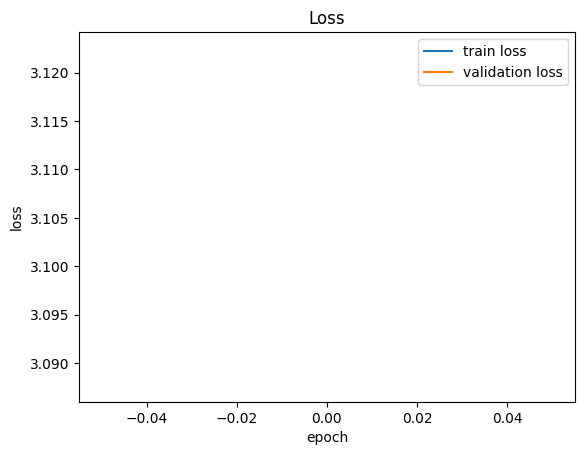

Epoch #02: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.0888935938748445, validation = 3.041980714797974
mean absolute error:  train = 3.1294598254545476, validation = 3.0838705100000006


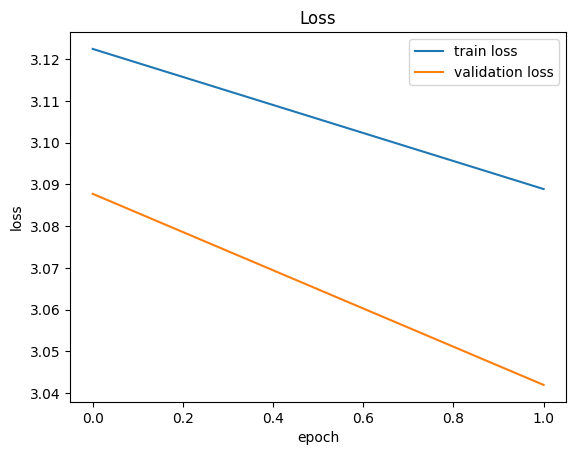

Epoch #03: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.0727953789450906, validation = 3.0391955471038816
mean absolute error:  train = 3.006900150909092, validation = 3.3034849100000003


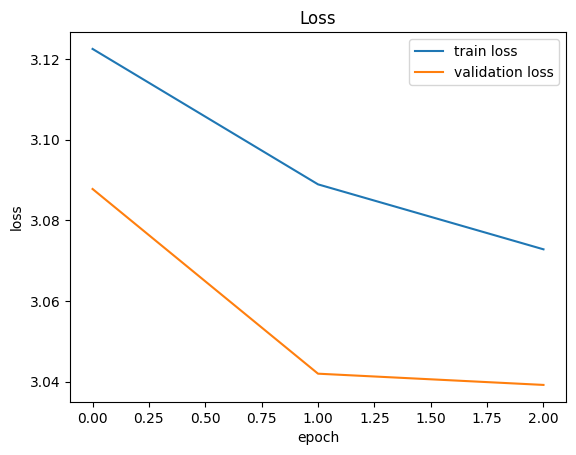

Epoch #04: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.067754784497348, validation = 3.064014406204224
mean absolute error:  train = 3.1568406236363615, validation = 3.4634346700000007


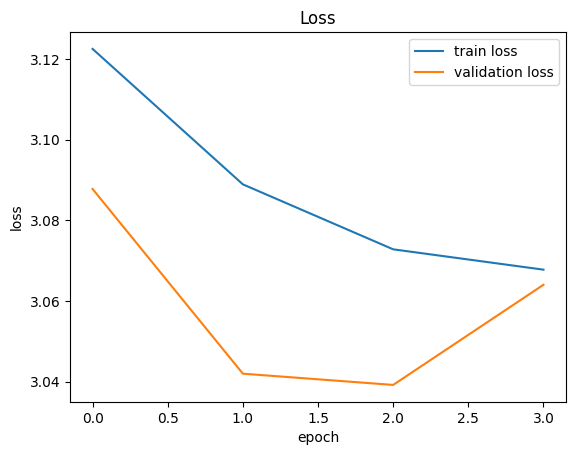

Epoch #05: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.073197260769931, validation = 3.0597378826141357
mean absolute error:  train = 3.021596621818183, validation = 3.0657048700000002


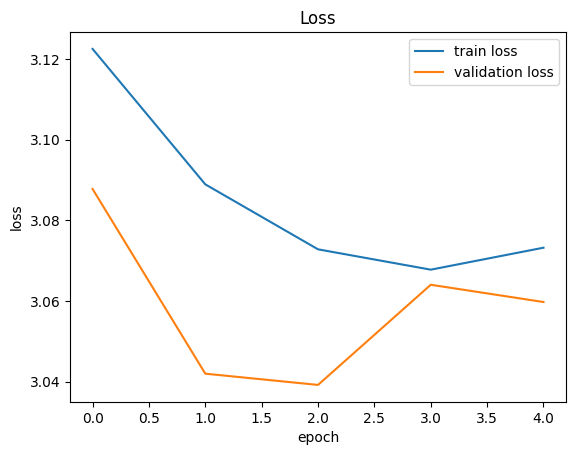

Epoch #06: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.0633878074992786, validation = 3.0597725772857665
mean absolute error:  train = 3.0471585872727274, validation = 3.1379818300000006


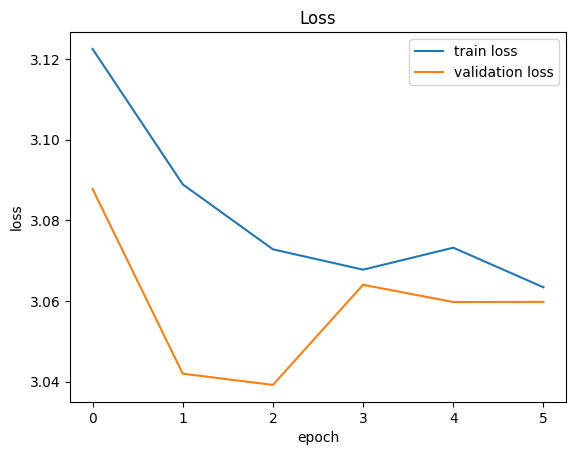

Epoch #07: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.050027905377475, validation = 3.0343780517578125
mean absolute error:  train = 3.068708781818182, validation = 3.2100694300000003


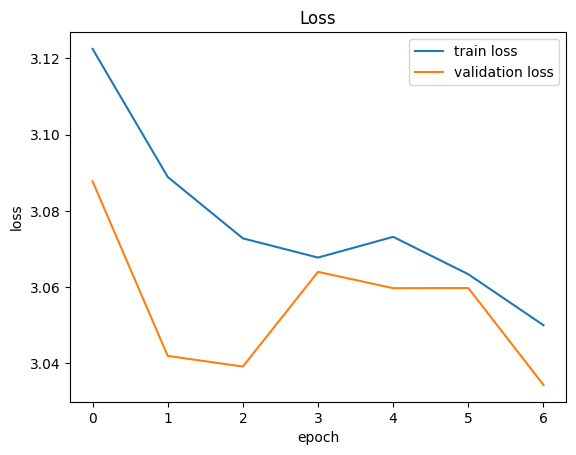

Epoch #08: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.0416272258758545, validation = 3.046375732421875
mean absolute error:  train = 3.076096416363637, validation = 3.3023144700000007


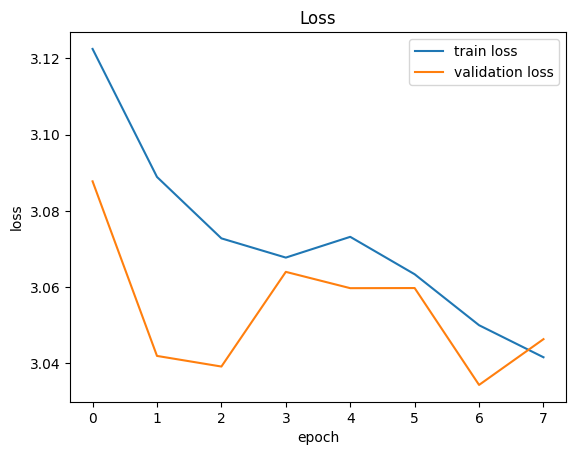

Epoch #09: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.019145919626409, validation = 3.071598834991455
mean absolute error:  train = 3.1061219163636364, validation = 3.1689035899999998


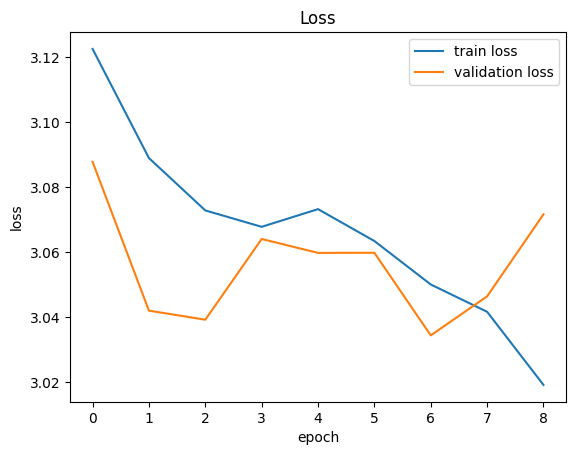

Epoch #10: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.0242222811959008, validation = 3.0562230014801024
mean absolute error:  train = 3.0981881854545463, validation = 3.2397477500000007


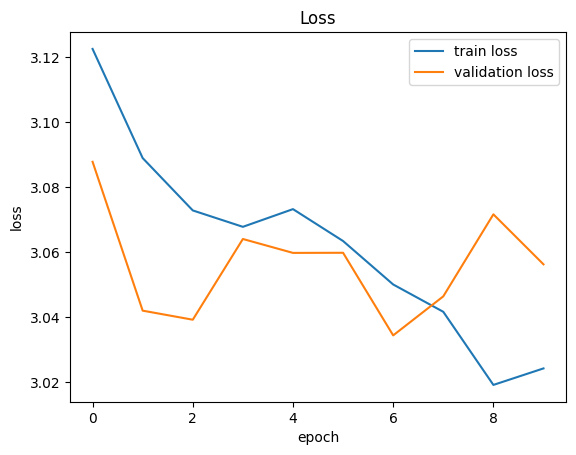

Epoch #11: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 3.011558253548362, validation = 3.072603693008423
mean absolute error:  train = 3.0898209490909103, validation = 3.225047770000001


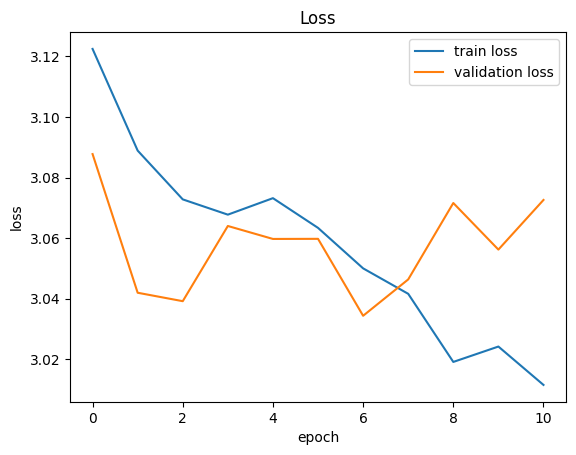

Epoch #12: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.9742091343619608, validation = 3.0695895862579348
mean absolute error:  train = 3.2541710109090904, validation = 3.285207470000001


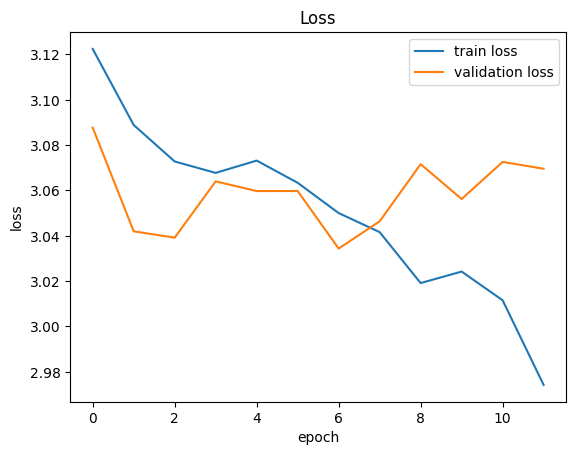

Epoch #13: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.9410563243519174, validation = 3.122469968795776
mean absolute error:  train = 3.9298831454545455, validation = 4.373464329999999


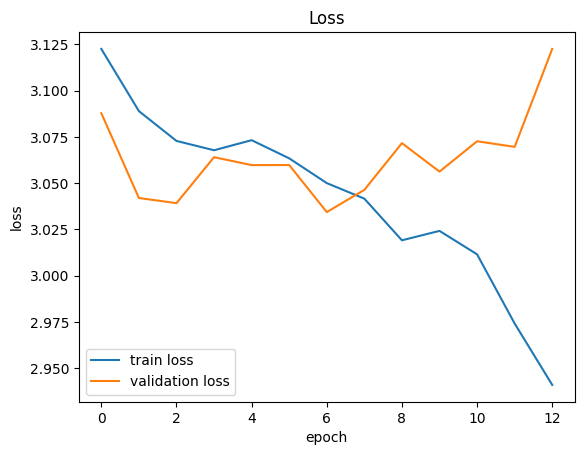

Epoch #14: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.9309975520047273, validation = 3.093975191116333
mean absolute error:  train = 4.218120123636364, validation = 3.77435643


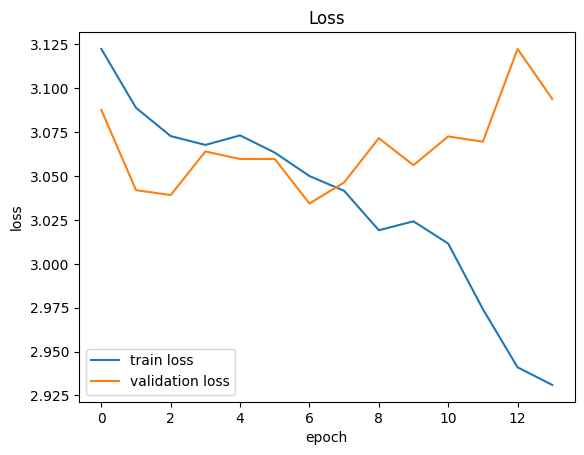

Epoch #15: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.9195007133483886, validation = 3.136330623626709
mean absolute error:  train = 4.183120649090908, validation = 4.53560213


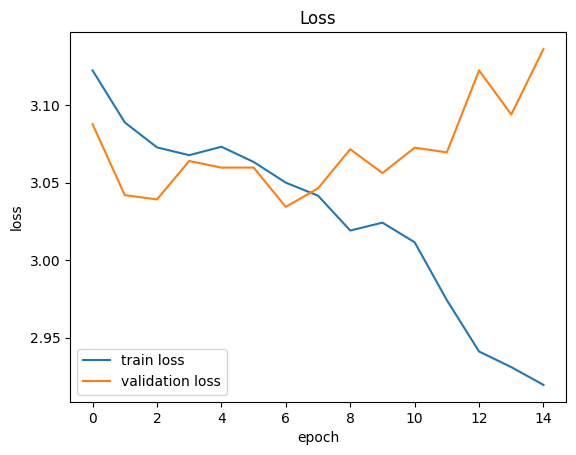

Epoch #16: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.8896304035186766, validation = 3.1657355880737303
mean absolute error:  train = 4.633687303636363, validation = 4.81186037


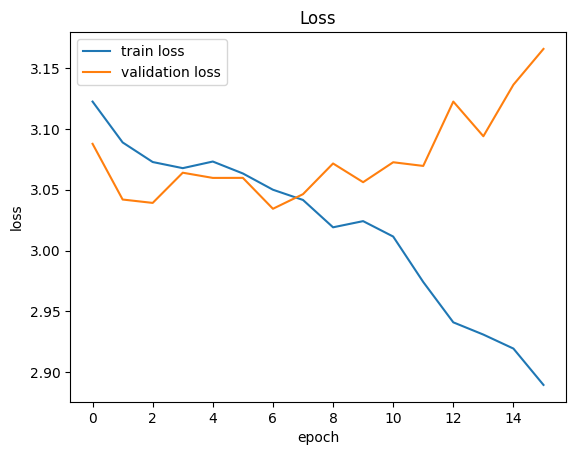

Epoch #17: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.886063294844194, validation = 3.159722671508789
mean absolute error:  train = 4.656390496363637, validation = 4.722864210000001


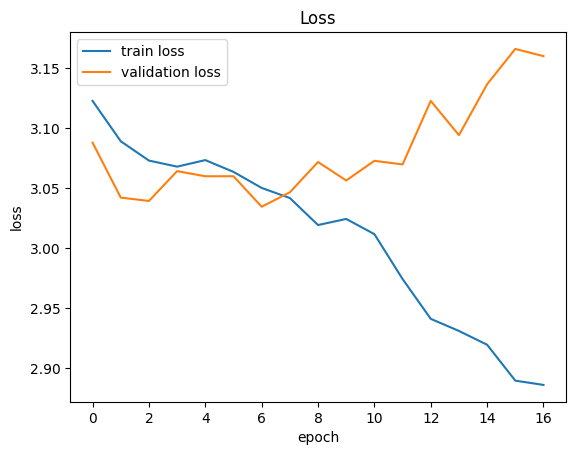

Epoch #18: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.840858472477306, validation = 3.1740848922729494
mean absolute error:  train = 4.910750112727271, validation = 5.301486209999999


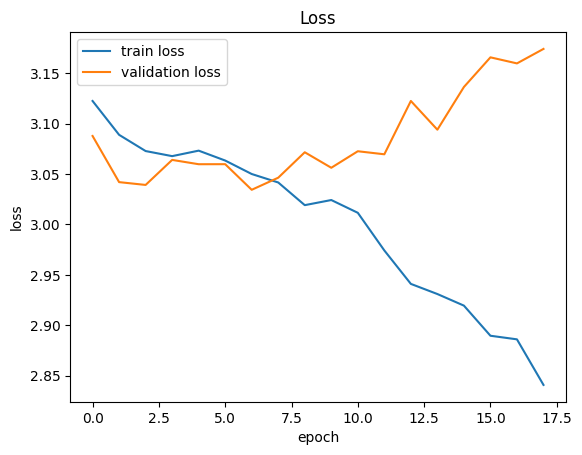

Epoch #19: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.8413023489171807, validation = 3.2188597774505614
mean absolute error:  train = 5.034463196363634, validation = 5.83024501


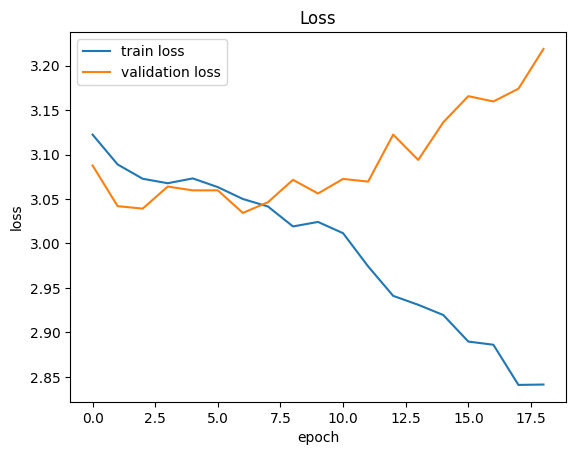

Epoch #20: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.822915610400113, validation = 3.18211256980896
mean absolute error:  train = 5.487548241818179, validation = 5.65593977


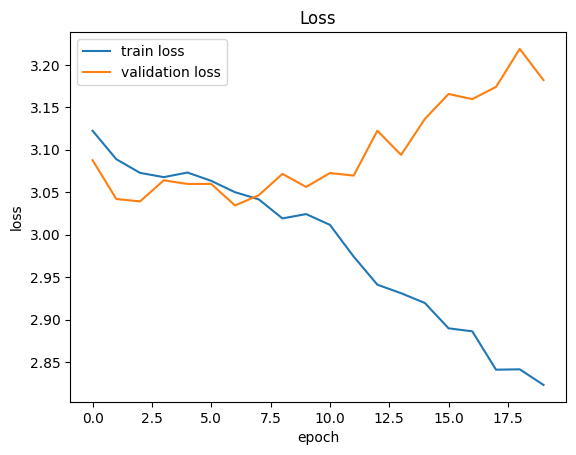

Epoch #21: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.8262856544147836, validation = 3.217107057571411
mean absolute error:  train = 5.421383085454543, validation = 5.635027090000001


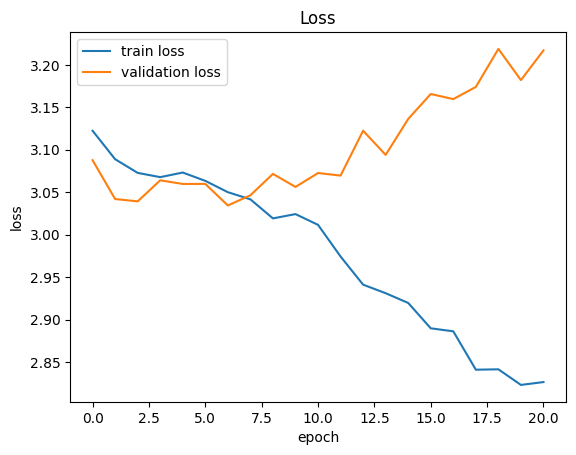

Epoch #22: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.797531174746427, validation = 3.178319501876831
mean absolute error:  train = 5.611356129090907, validation = 5.61869125


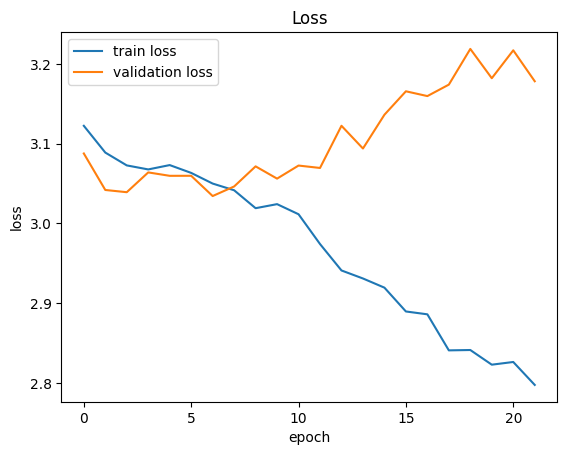

Epoch #23: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.761799743825739, validation = 3.28036922454834
mean absolute error:  train = 5.752538583636363, validation = 6.42751621


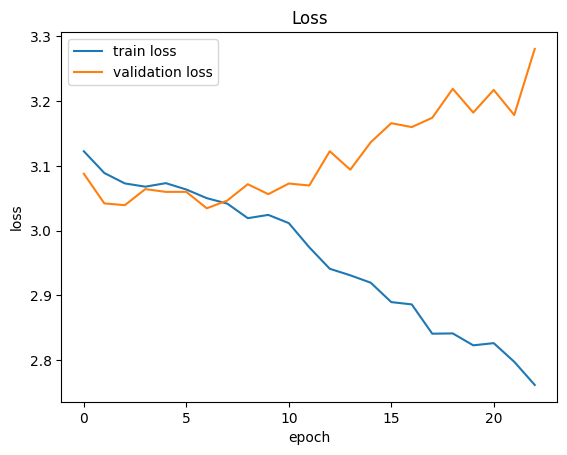

Epoch #24: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.7205277755043724, validation = 3.284025011062622
mean absolute error:  train = 6.180873461818183, validation = 6.526396010000001


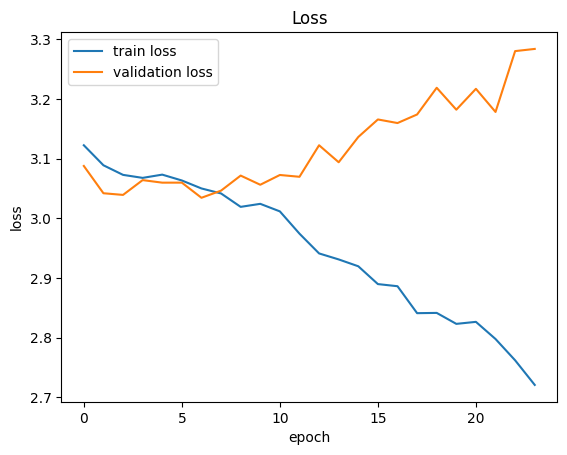

Epoch #25: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.7766887005892666, validation = 3.2588848209381105
mean absolute error:  train = 6.11865433090909, validation = 6.49595565


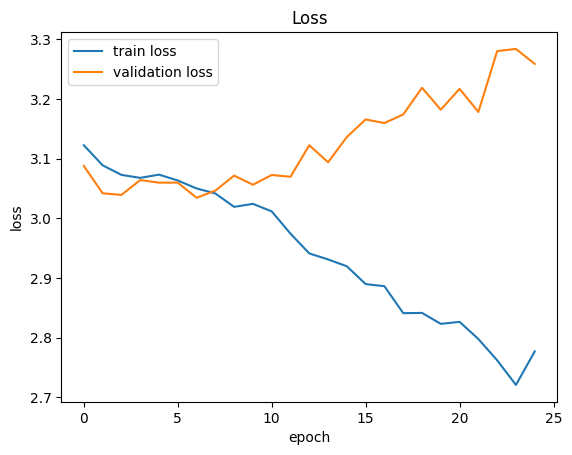

Epoch #26: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.6900514429265803, validation = 3.281475763320923
mean absolute error:  train = 6.361235987272727, validation = 6.237783150000001


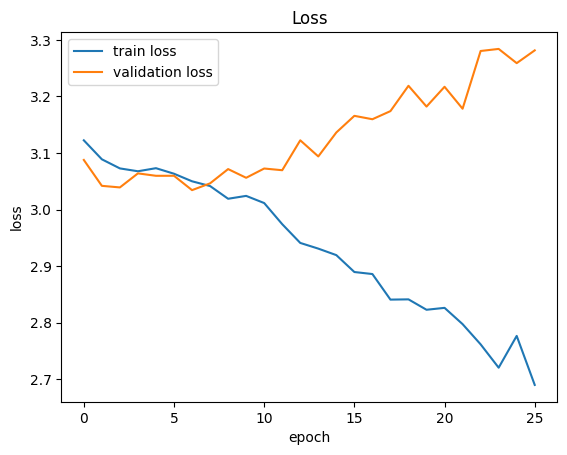

Epoch #27: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.6564140571247448, validation = 3.4017495250701906
mean absolute error:  train = 6.359459703636361, validation = 6.585163970000001


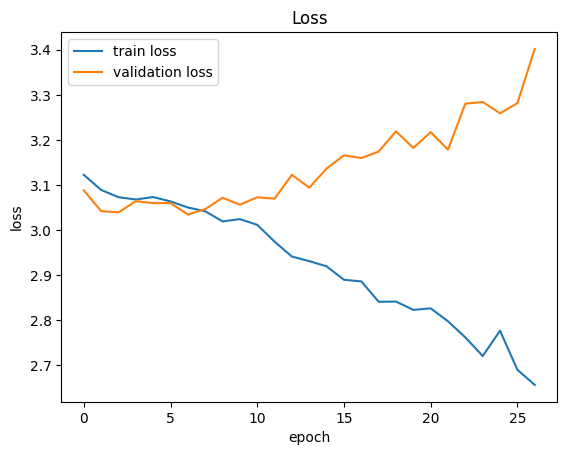

Epoch #28: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.6598715045235375, validation = 3.329930553436279
mean absolute error:  train = 6.380906414545453, validation = 6.78071947


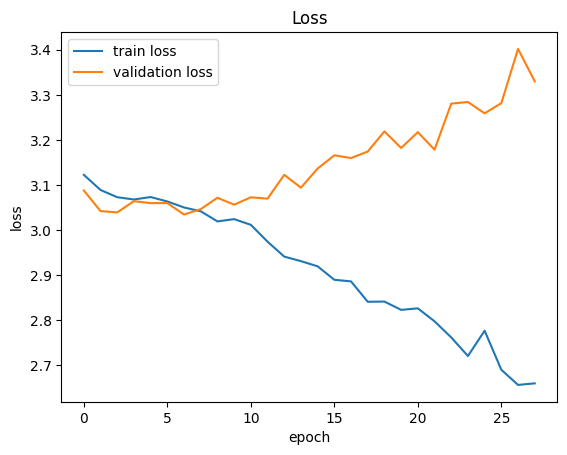

Epoch #29: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.630723374106667, validation = 3.3436767768859865
mean absolute error:  train = 6.5376494072727285, validation = 6.849403069999999


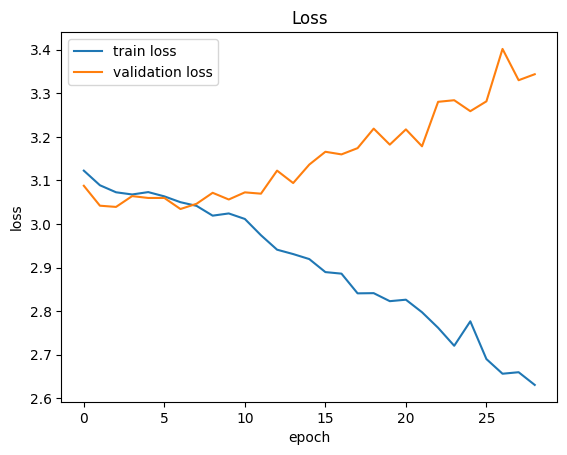

Epoch #30: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.648517053777521, validation = 3.3408590507507325
mean absolute error:  train = 6.578853232727272, validation = 6.69089293


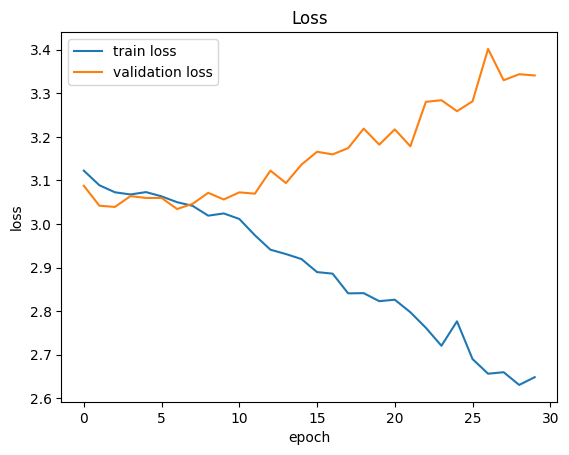

In [21]:
train_abs_log, val_abs_log = train(model_A, DEVICE, train_loader, val_loader, 0.008, 30)

Epoch #01: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.567303589040583, validation = 3.3767979621887205
mean absolute error:  train = 6.679653625454544, validation = 6.50591457


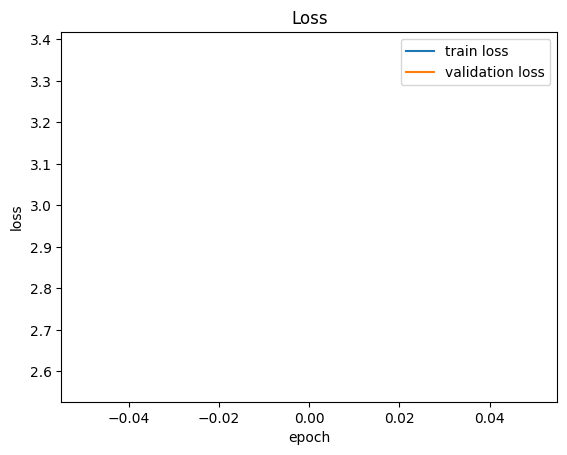

Epoch #02: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.482665513645519, validation = 3.5989648628234865
mean absolute error:  train = 6.784352150909086, validation = 7.17053245


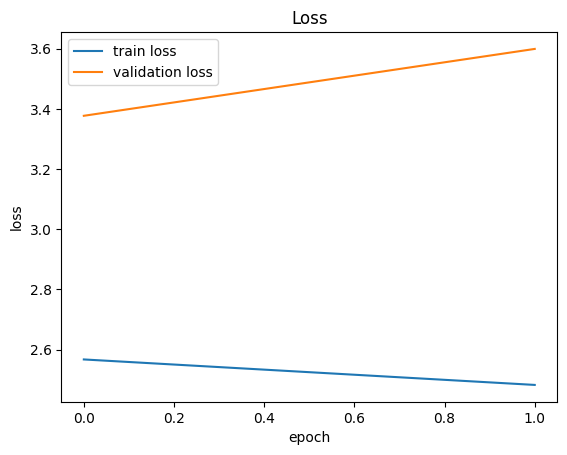

Epoch #03: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.4448606265674937, validation = 3.655559844970703
mean absolute error:  train = 6.847626378181817, validation = 7.1945068700000006


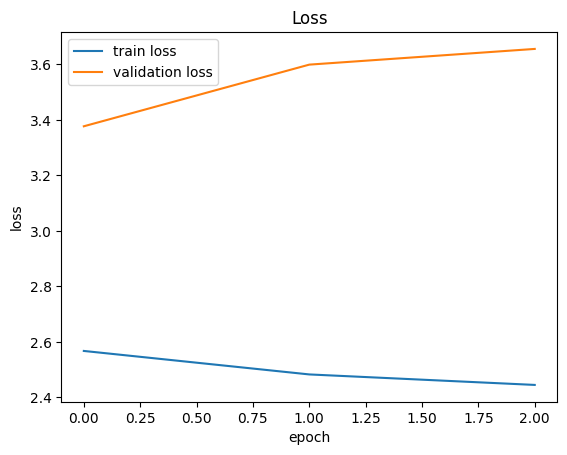

Epoch #04: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.422653937773271, validation = 3.6817597770690917
mean absolute error:  train = 6.943504447272725, validation = 6.63703257


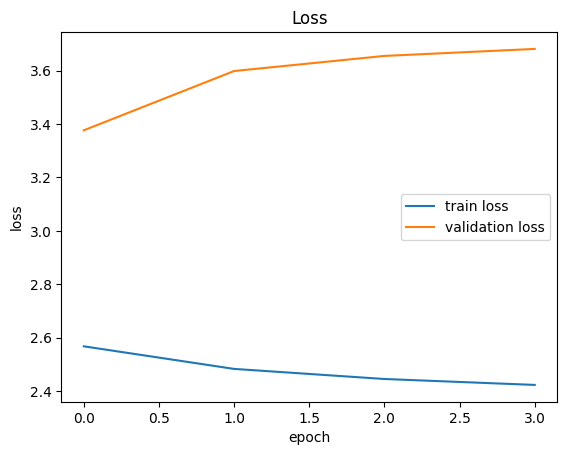

Epoch #05: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.3834216794100676, validation = 3.9335667419433595
mean absolute error:  train = 7.059035534545454, validation = 7.3205985899999995


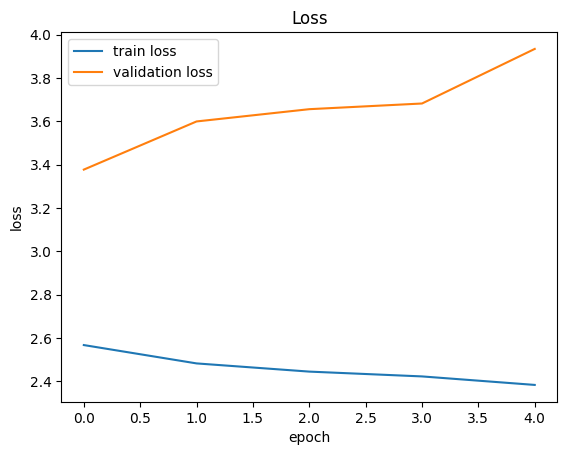

Epoch #06: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.353066344694658, validation = 3.9318446922302246
mean absolute error:  train = 7.144074825454544, validation = 6.9346871299999995


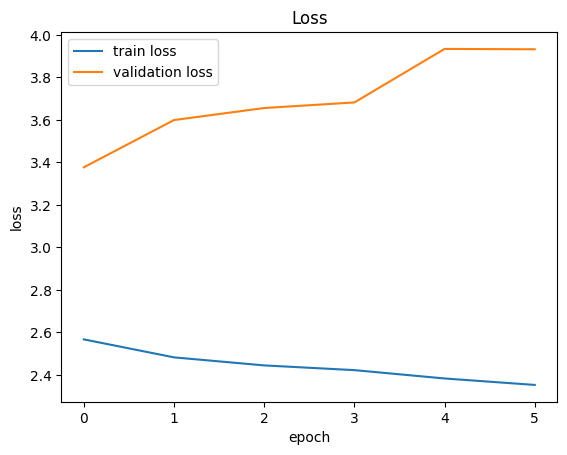

Epoch #07: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.3279285968433725, validation = 3.8929616928100588
mean absolute error:  train = 7.182230301818179, validation = 7.43852467


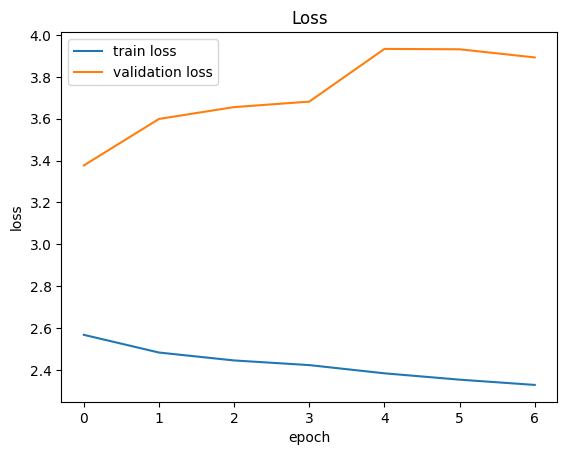

Epoch #08: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.3287350004369562, validation = 3.9115853309631348
mean absolute error:  train = 7.326698601818181, validation = 7.18852467


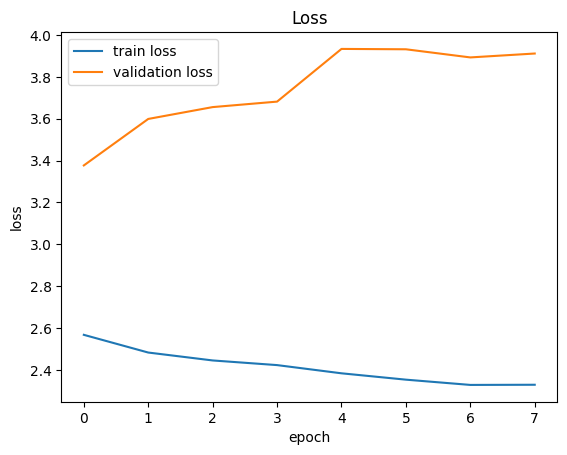

Epoch #09: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.323965087370439, validation = 3.9599414253234864
mean absolute error:  train = 7.371381147272727, validation = 7.19491069


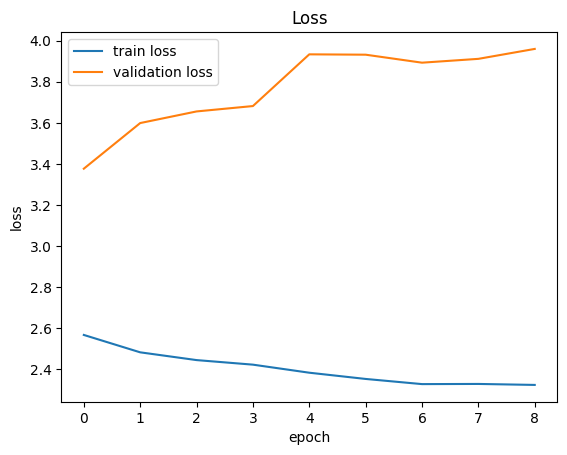

Epoch #10: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.284572805924849, validation = 4.0420536613464355
mean absolute error:  train = 7.383078407272728, validation = 7.540598589999999


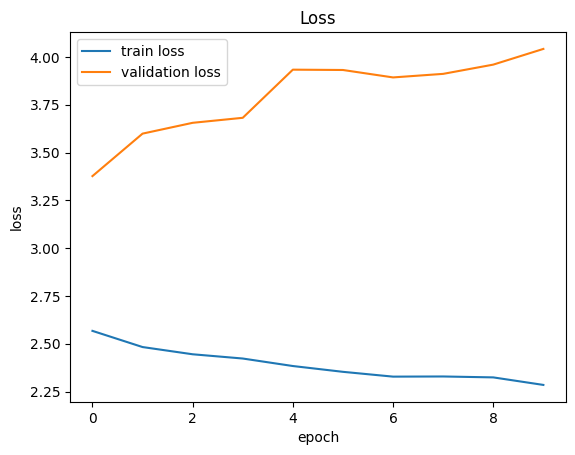

In [22]:
train_abs_log_1, val_abs_log_1 = train(model_A, DEVICE, train_loader, val_loader, 0.003, 10)

Epoch #01: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.26516638062217, validation = 4.102652397155762
mean absolute error:  train = 7.556666856363635, validation = 7.9842102299999995


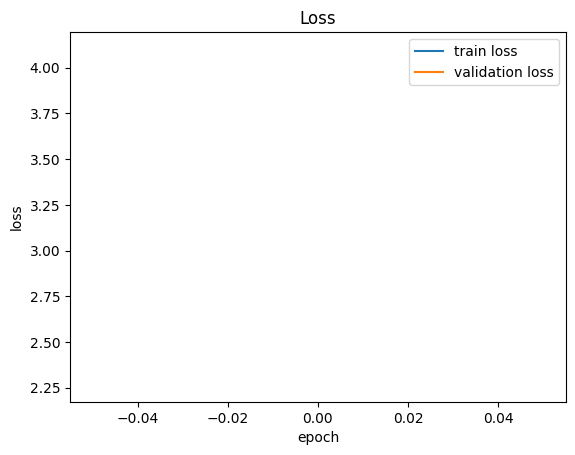

Epoch #02: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.3027954361655496, validation = 3.8078889656066894
mean absolute error:  train = 7.4645226218181815, validation = 7.66890569


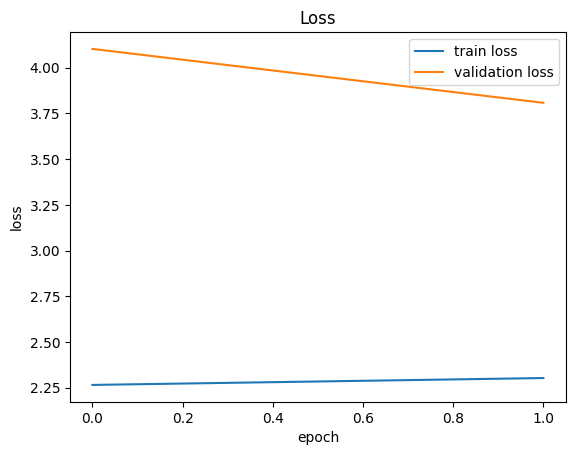

Epoch #03: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.3114645290374756, validation = 4.094199924468994
mean absolute error:  train = 7.564462465454544, validation = 7.64336155


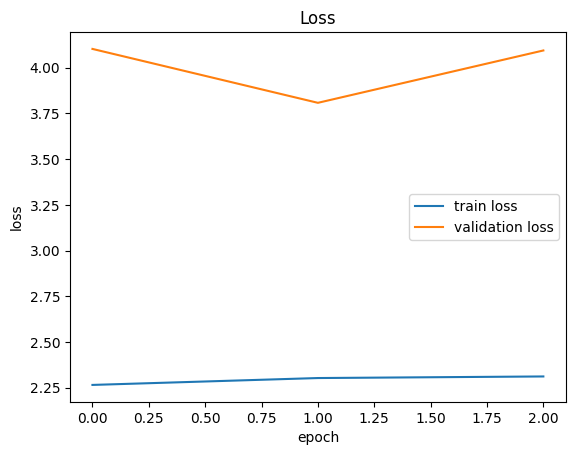

Epoch #04: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.284033503098921, validation = 3.9853120613098145
mean absolute error:  train = 7.672597618181817, validation = 7.682779730000001


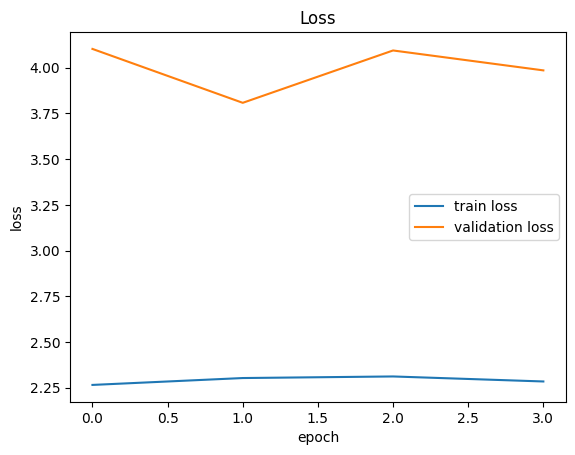

Epoch #05: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.2526952188665215, validation = 4.257107315063476
mean absolute error:  train = 7.661369932727273, validation = 7.94342087


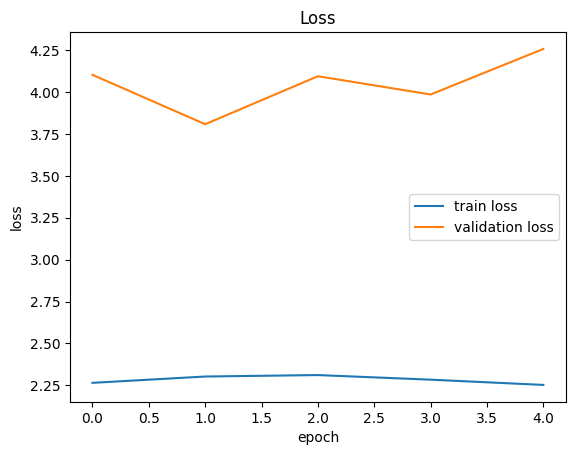

Epoch #06: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.23993391383778, validation = 4.246566619873047
mean absolute error:  train = 7.663995367272726, validation = 8.06487647


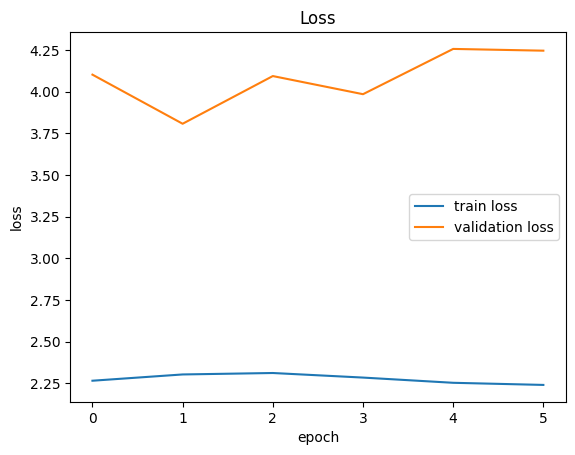

Epoch #07: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.2199349334023215, validation = 4.470794563293457
mean absolute error:  train = 7.705890292727272, validation = 8.08361021


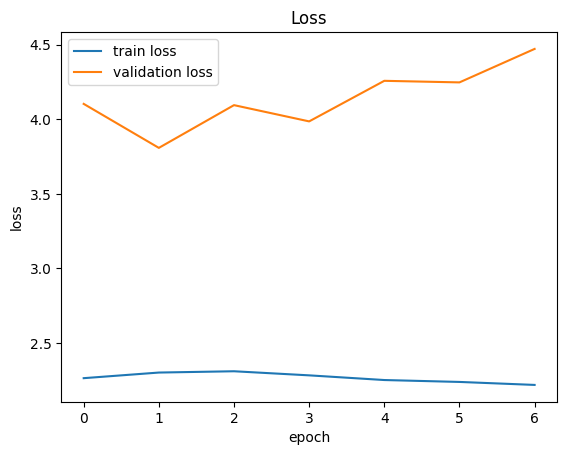

Epoch #08: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.2101725335554643, validation = 4.578450164794922
mean absolute error:  train = 7.74046582, validation = 7.9671603300000005


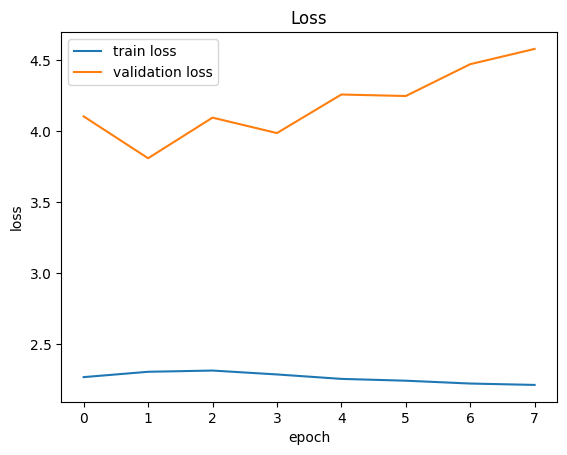

Epoch #09: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.205674042268233, validation = 4.593860168457031
mean absolute error:  train = 7.686197885454545, validation = 7.927516250000001


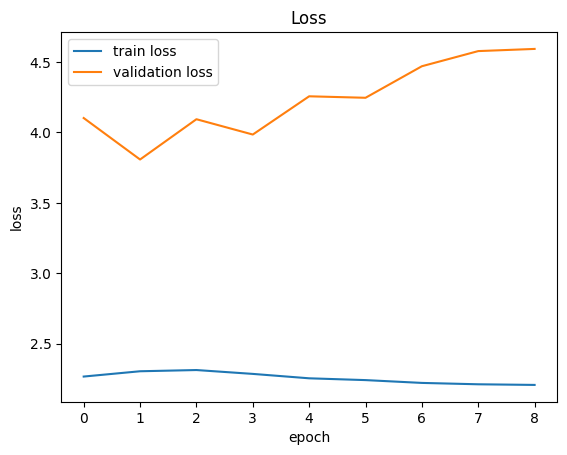

Epoch #10: 
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
CrossEntropyLoss:     train = 2.198604161522605, validation = 4.542576999664306
mean absolute error:  train = 7.809357403636363, validation = 7.93377679


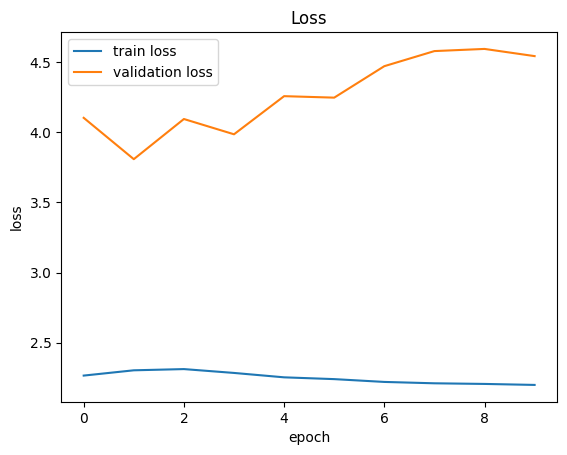

In [23]:
train_abs_log_2, val_abs_log_2 = train(model_A, DEVICE, train_loader, val_loader, 0.003, 10)

In [40]:
def train_L(model, loss_func, device, train_loader, val_loader, lr, epochs):
    train_abs_log = []
    val_abs_log = []
    model.train()
    abs_loss = loss_func
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
    f = plt.figure()
    for epoch in range(epochs):
        train_abs_loss = 0.0
        print(f"Epoch #{1 + epoch:02}: ")
        i = 0
        for data, age in train_loader:
            data_eo, data_ec = data
            data_eo = data_eo.to(device)           # shape = (batch_size, 1, 129, 10000)
            data_ec = data_ec.to(device)           # shape = (batch_size, 1, 129, 20000)
            batch_size = age.size(0)
            optimizer.zero_grad()
            output = model(data_eo, data_ec)       # shape = (batch_size, 25)
            loss = abs_loss(torch.squeeze(output), age.float().to(device))
            loss.backward()
            optimizer.step()
            print(i)
            i += batch_size
            train_abs_loss += loss.item() * batch_size
        train_abs_loss /= train_subj
        train_abs_log.append(train_abs_loss)
        val_abs_loss = 0.0
        for data, age in val_loader:
            data_eo, data_ec = data
            data_eo = data_eo.to(device)           # shape = (batch_size, 129, 10000)
            data_ec = data_ec.to(device)           # shape = (batch_size, 129, 20000)
            batch_size = age.size(0)
            output = model(data_eo, data_ec)       # shape = (batch_size, 25)
            print(output)
            print(age)
            loss = abs_loss(torch.squeeze(output), age.float().to(device))

            val_abs_loss += loss.item() * batch_size
        val_abs_loss /= val_subj
        val_abs_log.append(val_abs_loss)
        print(f"mean absolute error:  train = {train_abs_loss}, validation = {val_abs_loss}")
        plt.clf()
        plt.plot(train_abs_log, label='train loss')
        plt.plot(val_abs_log, label='validation loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss')
        plt.legend()
        plt.show()
    return train_abs_log, val_abs_log

In [29]:
model_A.set_state(1)

In [ ]:
train_L(model_A, nn.L1Loss(reduction='mean'), DEVICE, train_loader, val_loader, 0.003, 10)

In [ ]:
train_L(model_A, nn.L1Loss(reduction='mean'), DEVICE, val_loader, val_loader, 0.003, 5)